In [3]:
!pip install torch

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [14]:
data = pd.read_excel('Data/SemEval-2015-Scraped.xlsx')[['content', 'label']]

<AxesSubplot:ylabel='Density'>

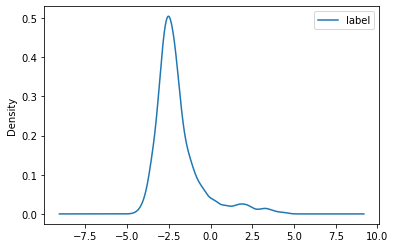

In [15]:
data.plot.kde()

In [16]:
labels = data.label.to_numpy()
print(np.mean(labels),np.std(labels))

-1.9915125 1.3768921934355465


In [17]:
import torch
import random

SEED = 2022

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
from transformers import BertTokenizer, BertModel

In [18]:
from transformers import AutoTokenizer, AutoModel

In [52]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [53]:
tokenizer.decode(tokenizer.encode('I love it 😄 😔 💗'))

In [19]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [20]:
tokenizer.decode(tokenizer.encode('I love it 😄 😔 💗'))

'<s> I love it 😄 😔 💗</s>'

In [22]:
# Load the special tokens and configurations
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

max_input_length = tokenizer.max_model_input_sizes['xlm-roberta-base']


In [23]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [25]:
X,y = data['content'].values, data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (6000,)
shape of test data is (2000,)


In [26]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

ValueError: Grouper and axis must be same length

In [65]:
def preprocess_string(s):
    # This cleans out all emojis!!!
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
#     word_list = []

#     stop_words = set(stopwords.words('english')) 
#     for sent in x_train:
#         for word in sent.lower().split():
#             word = preprocess_string(word)
#             if word not in stop_words and word != '':
#                 word_list.append(word)
  
#     corpus = Counter(word_list)
#     # sorting on the basis of most common words
#     corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
#     # creating a dict
#     onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
#     # tockenize
#     final_list_train,final_list_test = [],[]
#     for sent in x_train:
#             final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                      if preprocess_string(word) in onehot_dict.keys()])
#     for sent in x_val:
#             final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                     if preprocess_string(word) in onehot_dict.keys()])
    final_list_train, final_list_test = [], []
    for sent_1 in x_train:
        final_list_train = tokenizer(preprocess_string(sent_1))
    for sent_2 in x_val:
        final_list_test = tokenizer(preprocess_string(sent_2))
        
    encoded_train = [1 if label == True else 0 for label in y_train]  
    encoded_test = [1 if label == True else 0 for label in y_val]
    
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test)

In [ ]:
token_lens = []

for txt in data['content']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
print(max(token_lens))

In [27]:
class TweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          tweets,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'tweet_text': tweets,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.float32)
        }

In [28]:
def create_data_loader(X, y, tokenizer, max_len, batch_size):
    ds = TweetDataset(
    tweets=X,
    targets=y,
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size)

In [29]:
BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [30]:
len(train_data_loader)

375

In [31]:
dataiter = iter(train_data_loader)
sample = dataiter.next()
print(sample.keys())
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['targets'].shape)

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


## Model

In [32]:
bert = AutoModel.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
trial = nn.LSTM(input_size=768,
       hidden_size=512,
       num_layers=2,
       bidirectional=True,
       batch_first=True)
hidden = trial(bert(input_ids=sample['input_ids'],
          attention_mask=sample['attention_mask'])[0])[1][0]

In [ ]:
torch.flatten(hidden.transpose(0,1), start_dim = 1, end_dim= 2).shape

In [41]:
class BERT_BiLSTM_FFF_Cls(nn.Module):

    def __init__(self, bert, hidden_dim, bidirectional):
        super(BERT_BiLSTM_FFF_Cls, self).__init__()
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.hidden_dim = hidden_dim
        self.bert = bert
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=self.hidden_dim,
                           num_layers=2,
                           bidirectional=self.bidirectional,
                           batch_first=True)
        
        self.drop = nn.Dropout(p=0.25)
        
        self.out = nn.Sequential(
                    nn.Linear(self.hidden_dim * 4, 512),
                    nn.ReLU(),
                    nn.Linear(512, 1)
                   )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )[0]
        
        last_hidden = self.lstm(embeddings)[1][0]
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        last_hidden = self.drop(torch.flatten(last_hidden.transpose(0,1), start_dim=1, end_dim=2))
        
        return self.out(last_hidden).ravel()

In [ ]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [42]:
hidden_dim = 512
bidirectional = True
EPOCHS = 10
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

baseline_1 = BERT_BiLSTM_FFF_Cls(bert, hidden_dim, bidirectional)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(baseline_1.parameters(), lr=lr)


cpu


## Training 

In [47]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
#         print(outputs.dtype)
#         _,preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
#         prediction_error += torch.sum(torch.abs(targets - outputs))
#         correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
        print(f'Iteration loss: {loss.item()}')
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

#     return correct_predictions.double() / n_examples, np.mean(losses)
    return np.mean(losses), np.mean(losses)

In [44]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
#             _, preds = torch.max(outputs, dim=1)
#             prediction_error += torch.sum(torch.abs(targets - outputs))
            loss = loss_fn(outputs, targets)
            
#             correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
            losses.append(loss.item())

#     return correct_predictions.double() / n_examples, np.mean(losses)
    return np.mean(losses), np.mean(losses)

In [48]:
history = defaultdict(list)
best_accuracy = 0
baseline_1.to(device)

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    baseline_1,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device,
    len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    baseline_1,
    test_data_loader,
    loss_fn, 
    device, 
    len(X_test)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(baseline_1.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/10
----------
Iteration loss: 0.7799904942512512


  0%|          | 1/375 [00:02<17:16,  2.77s/it]

Iteration loss: 1.3147494792938232


  1%|          | 2/375 [00:05<16:35,  2.67s/it]

Iteration loss: 1.2357288599014282


  1%|          | 3/375 [00:08<16:55,  2.73s/it]

Iteration loss: 3.205643653869629


  1%|          | 4/375 [00:10<16:33,  2.68s/it]

Iteration loss: 3.4536702632904053


  1%|▏         | 5/375 [00:13<16:03,  2.60s/it]

Iteration loss: 1.6182652711868286


  2%|▏         | 6/375 [00:15<15:33,  2.53s/it]

Iteration loss: 1.3090646266937256


  2%|▏         | 7/375 [00:18<15:21,  2.50s/it]

Iteration loss: 0.43229442834854126


  2%|▏         | 8/375 [00:20<15:15,  2.49s/it]

Iteration loss: 2.0228652954101562


  2%|▏         | 9/375 [00:23<15:08,  2.48s/it]

Iteration loss: 2.543642520904541


  3%|▎         | 10/375 [00:25<14:57,  2.46s/it]

Iteration loss: 0.6657606959342957


  3%|▎         | 11/375 [00:27<14:49,  2.44s/it]

Iteration loss: 0.5885132551193237


  3%|▎         | 12/375 [00:30<15:07,  2.50s/it]

Iteration loss: 0.4770420789718628


  3%|▎         | 13/375 [00:33<15:32,  2.57s/it]

Iteration loss: 0.59141606092453


  4%|▎         | 14/375 [00:35<15:31,  2.58s/it]

Iteration loss: 0.48445501923561096


  4%|▍         | 15/375 [00:38<15:28,  2.58s/it]

Iteration loss: 5.235469818115234


  4%|▍         | 16/375 [00:41<15:36,  2.61s/it]

Iteration loss: 2.6672439575195312


  5%|▍         | 17/375 [00:43<15:23,  2.58s/it]

Iteration loss: 3.5309414863586426


  5%|▍         | 18/375 [00:46<15:11,  2.55s/it]

Iteration loss: 1.112640142440796


  5%|▌         | 19/375 [00:48<15:10,  2.56s/it]

Iteration loss: 3.093787670135498


  5%|▌         | 20/375 [00:51<15:19,  2.59s/it]


KeyboardInterrupt: 

In [35]:
np.sum(y_test, axis = 0)/y_test.shape[0]